# **Importation des Librairies**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

Utilisation de Cuda

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# **Importation des données**

In [3]:
# Importer les fichiers CSV
data_test_FD001 = pd.read_csv('/content/test_FD001.csv')
data_train_FD001 = pd.read_csv('/content/train_FD001.csv')
data_test_FD002 = pd.read_csv('/content/test_FD002.csv')
data_train_FD002 = pd.read_csv('/content/train_FD002.csv')
data_test_FD003 = pd.read_csv('/content/test_FD003.csv')
data_train_FD003 = pd.read_csv('/content/train_FD003.csv')
data_test_FD004 = pd.read_csv('/content/test_FD004.csv')
data_train_FD004 = pd.read_csv('/content/train_FD004.csv')

# Fusionner les données test
data_test = pd.concat([data_test_FD001, data_test_FD002, data_test_FD003, data_test_FD004], ignore_index=True)

# Fusionner les données train
data_train = pd.concat([data_train_FD001, data_train_FD002, data_train_FD003, data_train_FD004], ignore_index=True)

print("Dataset fusionnés et traités")

Dataset fusionnés et traités


# **Exploration des données**

In [4]:
# Creation des données d'entrainement, selection des colonnes des capteurs et des paramètres
X_train = data_train.iloc[:, 1:25]
Y_train = data_train.iloc[:, 25:26]
X_test = data_test.iloc[:, 1:25]
Y_test = data_test.iloc[:, 25:26]

# **Valeurs aberrantes**

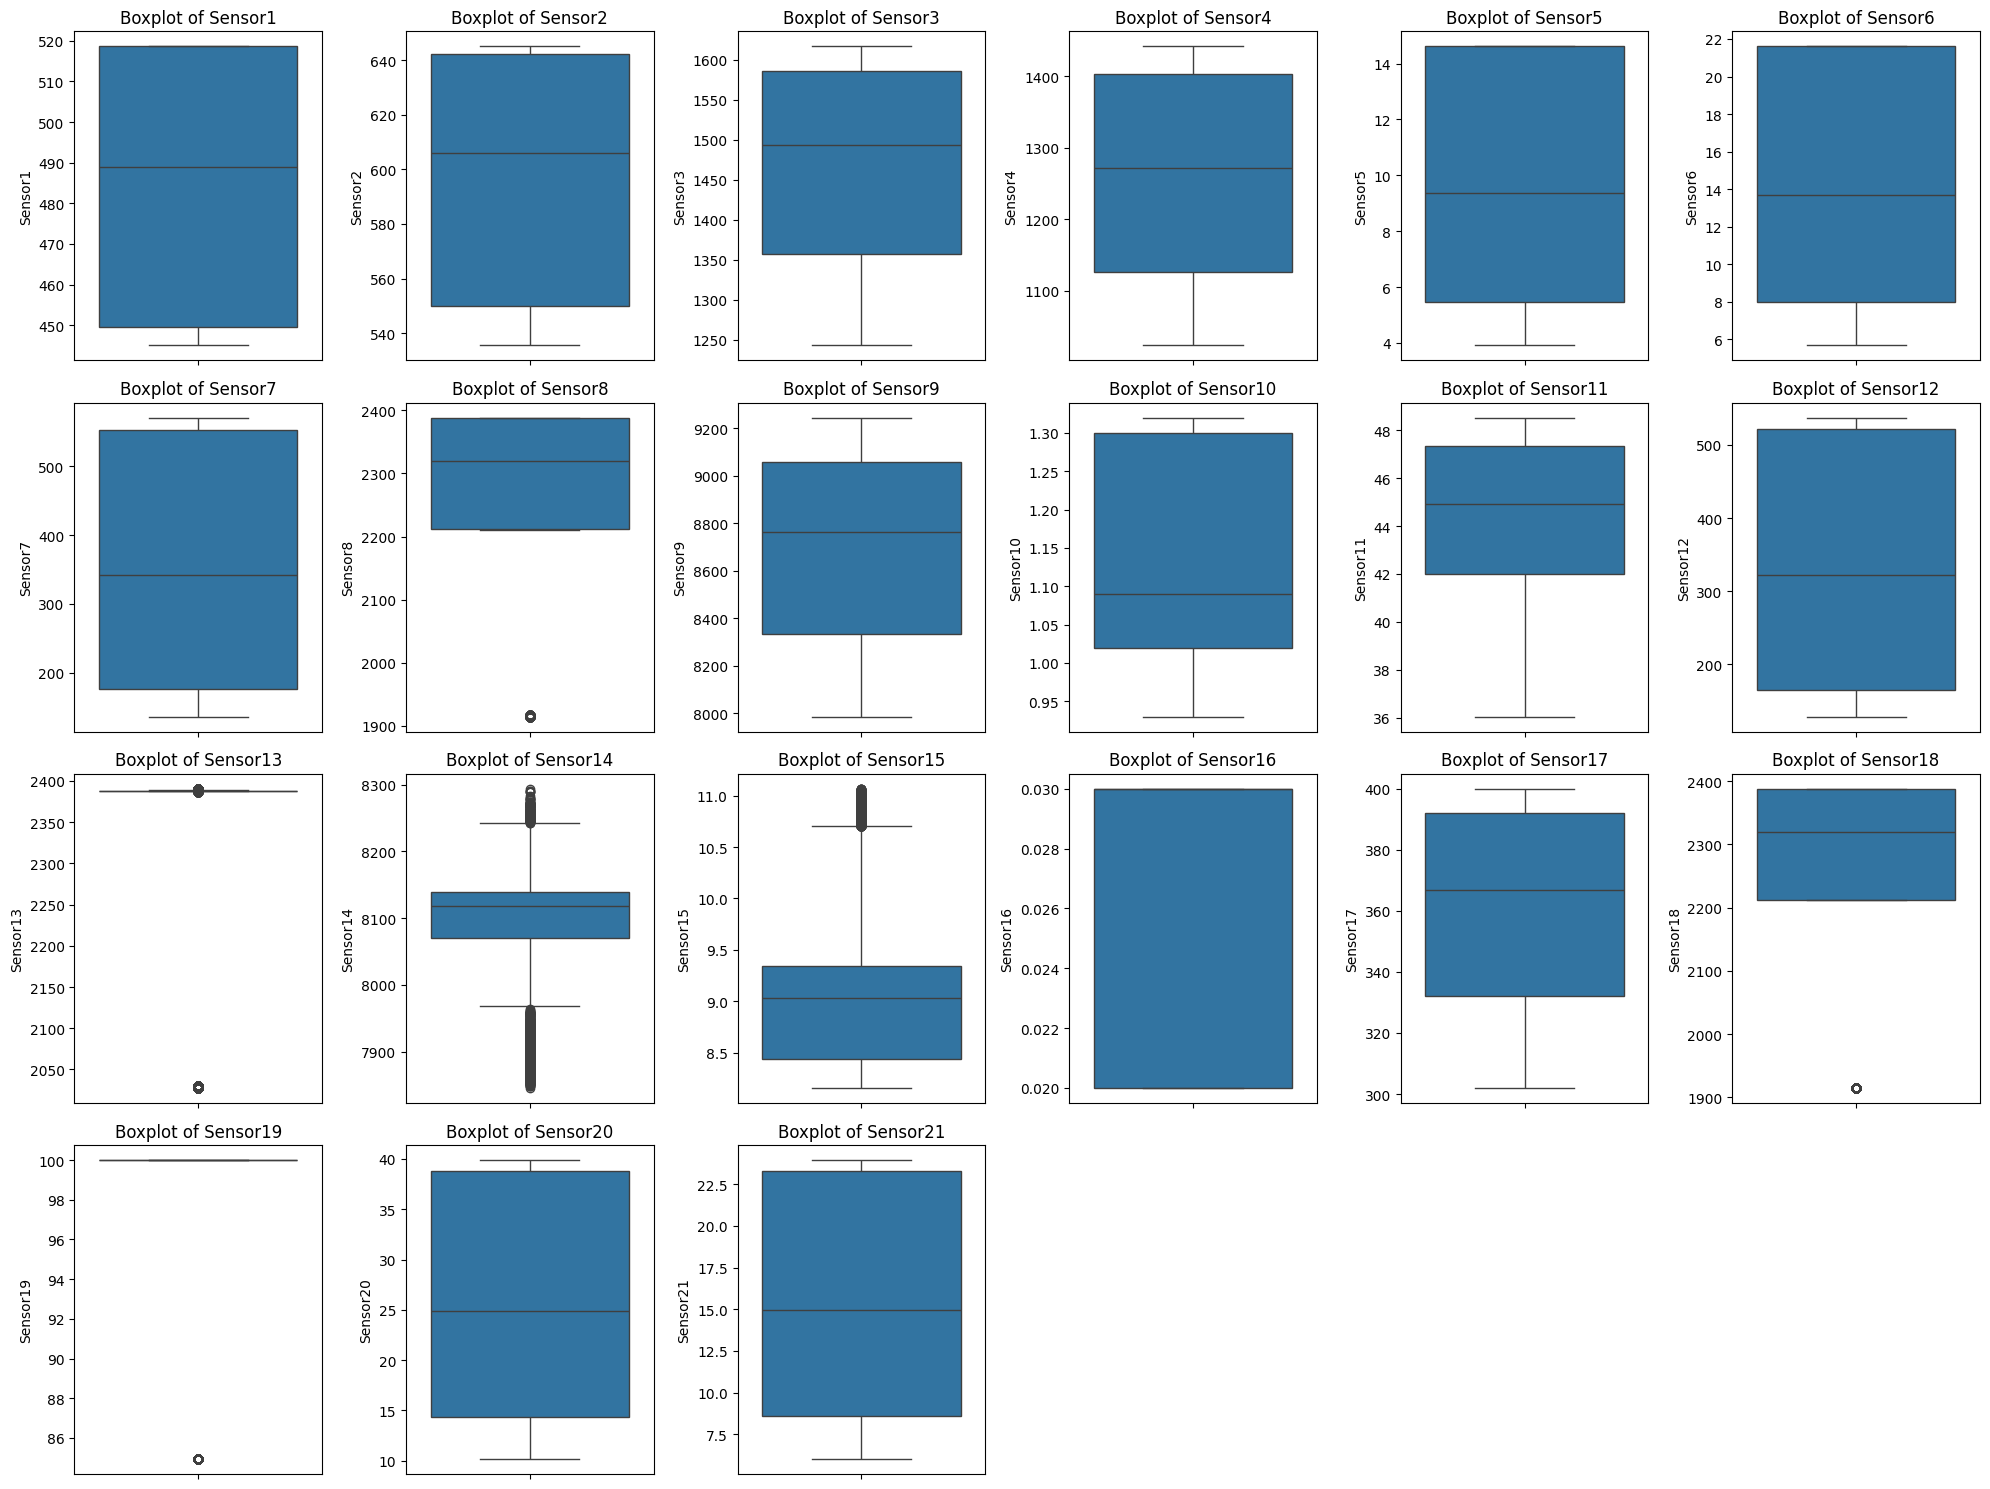

In [5]:
# Enlever les valeurs aberrantes des colonnes sensor en utilisant le diagramme moustache
X_train_Sensor_values = data_train.iloc[:, 4:25]
features = X_train_Sensor_values.columns

# Tracer les boxplots pour chaque feature avant le filtrage
plt.figure(figsize=(20, 15))  # Ajustez la taille de la figure selon vos besoins
for i, feature in enumerate(features):
    plt.subplot(4, 6, i+1)  # Ajustez la disposition des sous-plots selon le nombre de features
    sns.boxplot(y=X_train_Sensor_values[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
    plt.xlabel('')

plt.tight_layout()  # Ajuste les sous-plots pour qu'ils tiennent bien dans la figure
plt.show()

In [6]:
#Supprimer les data constante et inutile
X_train_processed_data = X_train.drop(columns=['Sensor13','Sensor19','Parameter3'])
X_test_processed_data = X_test.drop(columns=['Sensor13','Sensor19','Parameter3'])

# Fonction pour identifier les valeurs aberrantes
def identify_outliers(df):
    # Calcul des quartiles et de l'IQR pour les colonnes sélectionnées
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identification des valeurs aberrantes
    outliers = (df < lower_bound) | (df > upper_bound)
    return outliers

# Identifier les valeurs aberrantes dans chaque colonne
outliers = identify_outliers(X_train_processed_data)

# Supprimer les lignes avec des valeurs aberrantes
X_train_processed_data = X_train_processed_data[~outliers.any(axis=1)]

# Enregistrer les lignes correspondantes de Y_train
Y_train_processed_data = Y_train[~outliers.any(axis=1)]

Boxplot après filtrage et suppression des capteurs

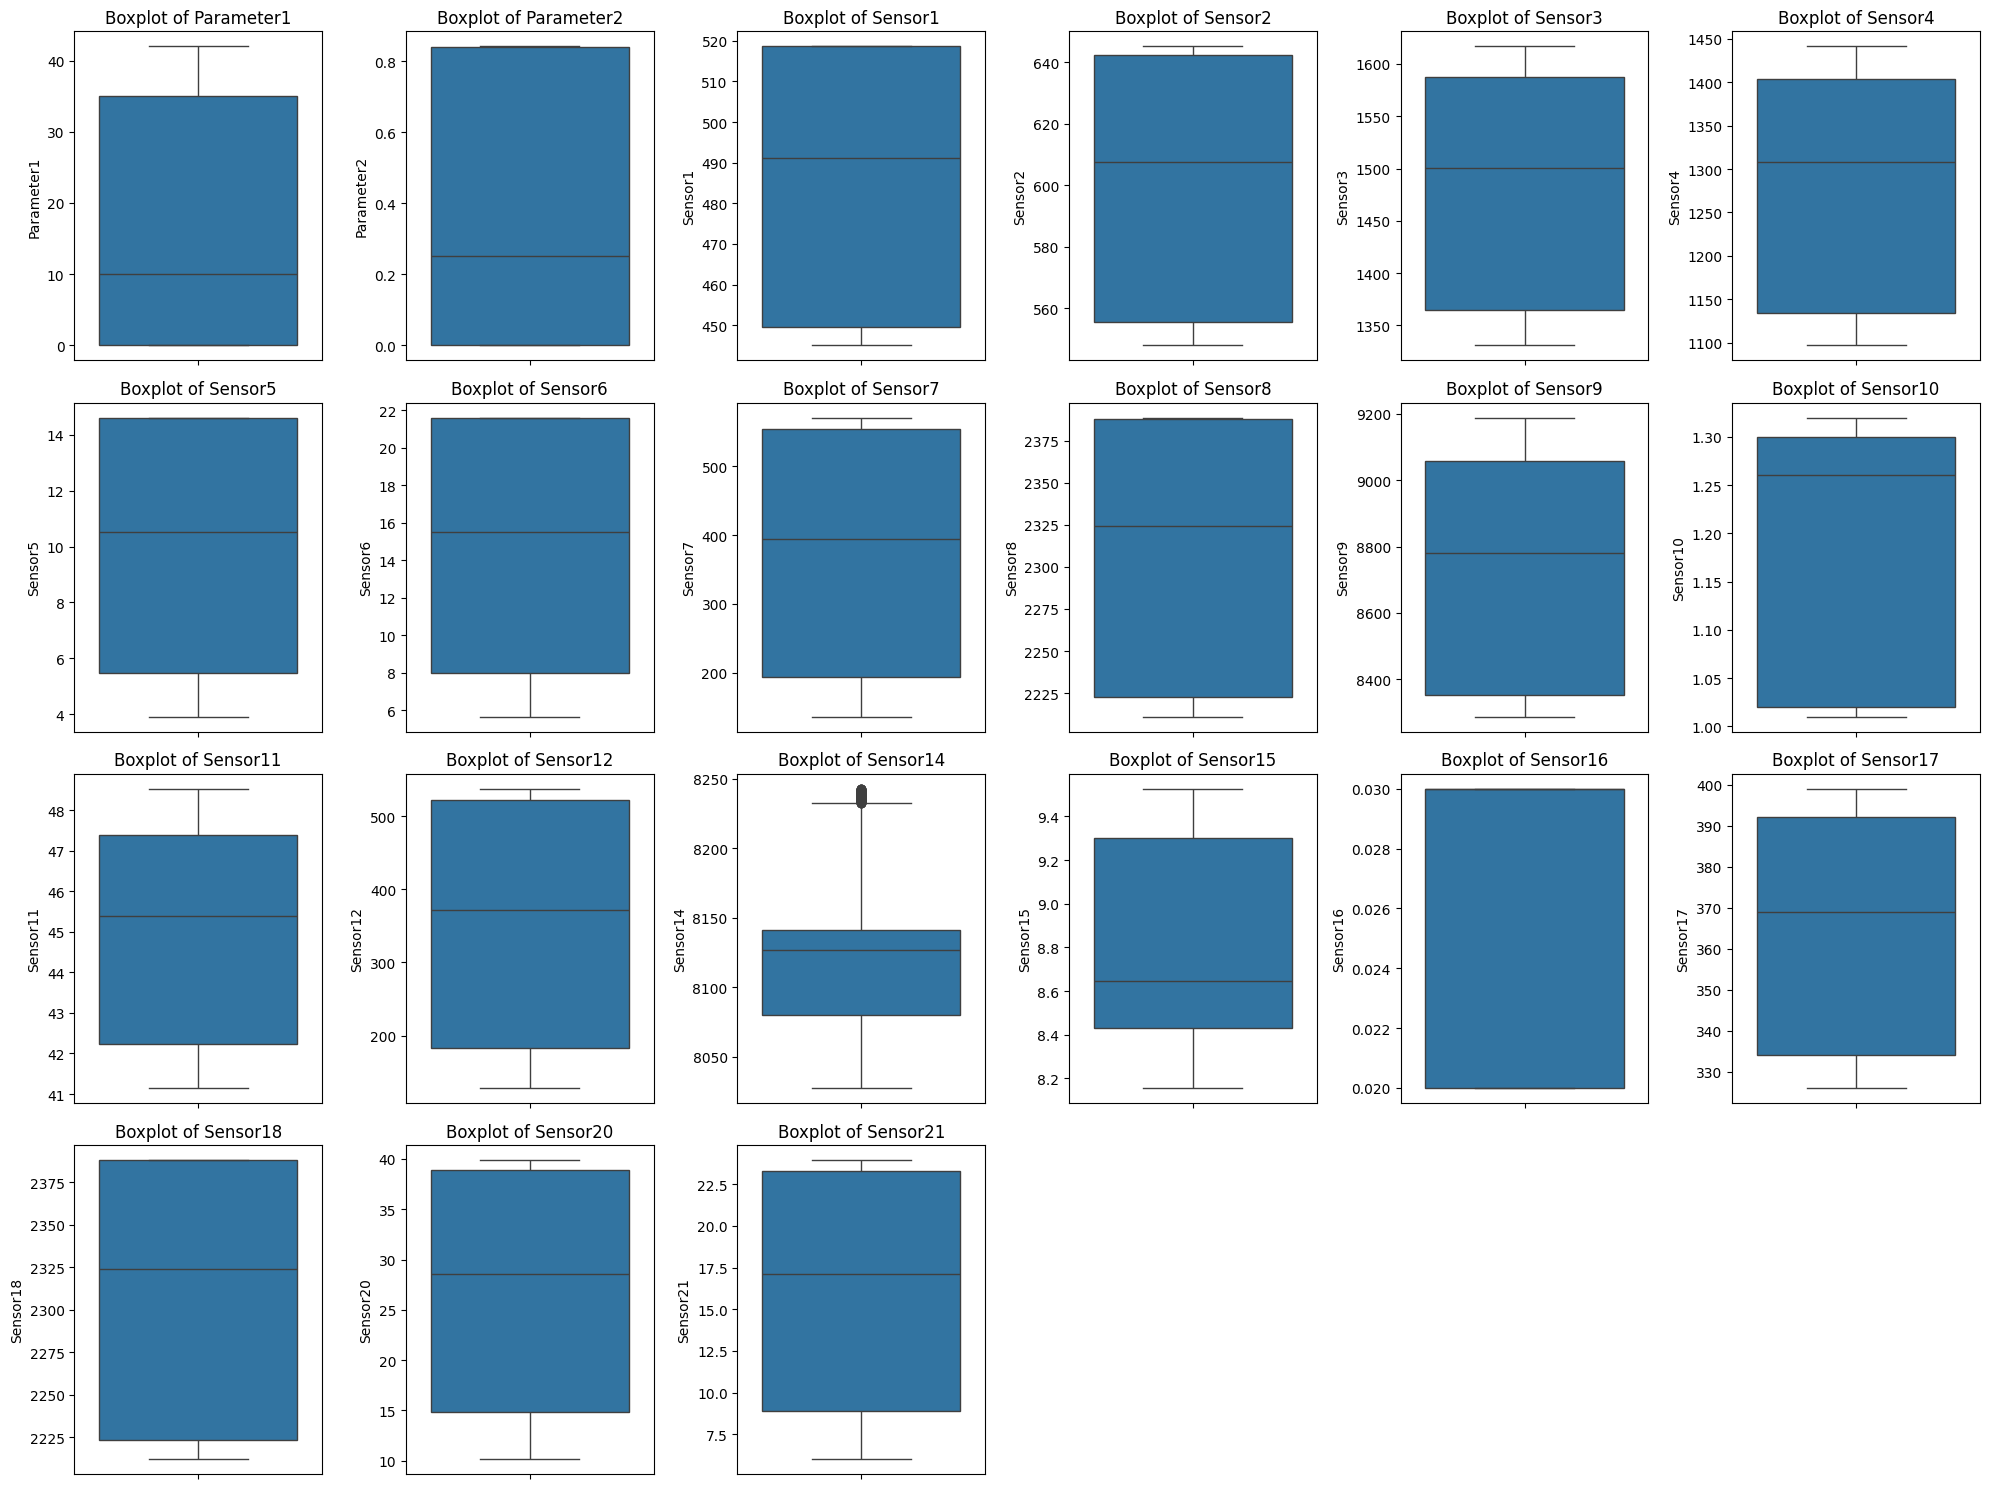

In [7]:
#New features filtered
features = X_train_processed_data.columns

# Tracer les boxplots pour chaque feature avant le filtrage
plt.figure(figsize=(20, 15))  # Ajustez la taille de la figure selon vos besoins
for i, feature in enumerate(features):
    plt.subplot(4, 6, i+1)  # Ajustez la disposition des sous-plots selon le nombre de features
    sns.boxplot(y=X_train_processed_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
    plt.xlabel('')

plt.tight_layout()  # Ajuste les sous-plots pour qu'ils tiennent bien dans la figure
plt.show()

In [8]:
# Afficher le Dataset filtré X_train
X_train_processed_data

,Parameter1,Parameter2,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,...,Sensor10,Sensor11,Sensor12,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor20,Sensor21
0,-0.0007,-0.0004,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,...,1.30,47.47,521.66,8138.62,8.4195,0.03,392,2388,39.06,23.4190
1,0.0019,-0.0003,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,...,1.30,47.49,522.28,8131.49,8.4318,0.03,392,2388,39.00,23.4236
2,-0.0043,0.0003,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,...,1.30,47.27,522.42,8133.23,8.4178,0.03,390,2388,38.95,23.3442
3,0.0007,0.0000,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,...,1.30,47.13,522.86,8133.83,8.3682,0.03,392,2388,38.88,23.3739
4,-0.0019,-0.0002,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,...,1.30,47.28,522.19,8133.80,8.4294,0.03,393,2388,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,9.9998,0.2500,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,...,1.27,46.08,380.16,8185.69,8.4541,0.03,372,2319,29.11,17.5234
160355,0.0028,0.0015,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,...,1.31,48.04,535.02,8185.47,8.2221,0.03,396,2388,39.38,23.7151
160356,0.0029,0.0000,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,...,1.31,48.24,535.41,8193.94,8.2525,0.03,395,2388,39.78,23.8270
160357,35.0046,0.8400,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,...,1.05,42.53,187.92,8125.64,9.0515,0.02,337,2223,15.26,9.0774


In [9]:
# Afficher le Dataset filtré Y_train
Y_train_processed_data

,RUL
0,191
1,190
2,189
3,188
4,187
...,...
160354,4
160355,3
160356,2
160357,1


Matrice de corrélation après filtrage et suppresion de 3 features (parameter3, capteur13, capteur19) :

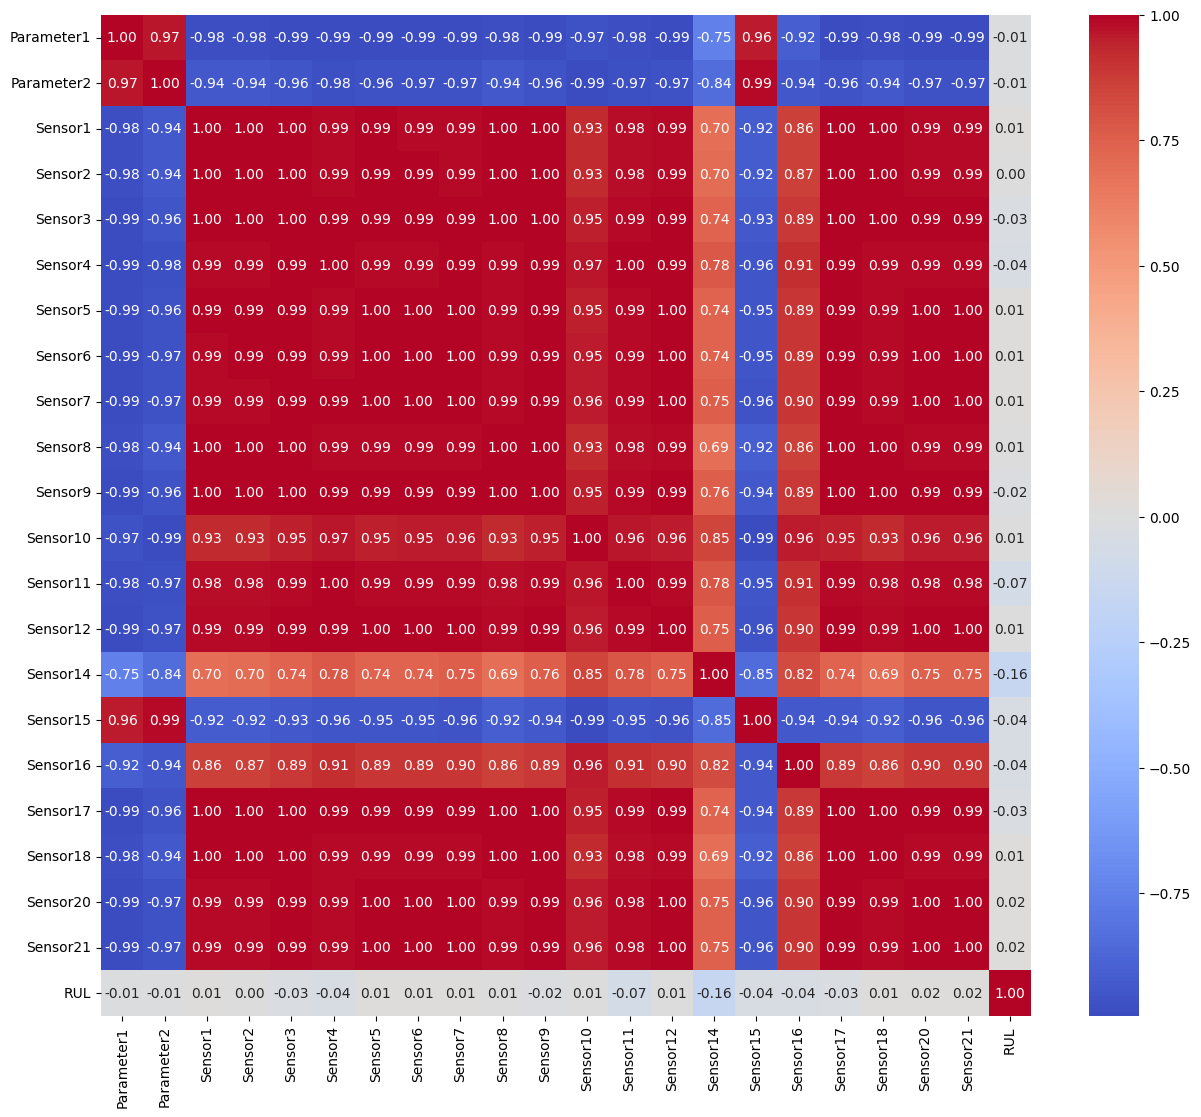

In [11]:
df = pd.concat([X_train_processed_data, Y_train_processed_data], axis=1)
df = pd.DataFrame(df)

correlation_matrix = df.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True ,cmap='coolwarm', fmt=".2f")
plt.show()

**Conclusion : Toutes les données de capteurs restant semblent être corrélés, ainsi pour un premier test nous allons tous les utiliser avec le filtrage des valeurs aberrantes en faisant varier les hyper paramètres.**

# **Entrainement du modèle avec couches de neurones**

Normalisation et transformation des données en torch :

La normalisation via standardscaler + tanh pour avoir nos données entre [-1;1]

In [12]:

# Convertir les DataFrames pandas en numpy.ndarray si nécessaire
if isinstance(X_train_processed_data, pd.DataFrame):
    X_train_processed_data = X_train_processed_data.values

if isinstance(X_test_processed_data, pd.DataFrame):
    X_test_processed_data = X_test_processed_data.values

if isinstance(Y_train_processed_data, pd.DataFrame):
    Y_train_processed_data = Y_train_processed_data.values

if isinstance(Y_test, pd.DataFrame):
    Y_test_processed_data = Y_test.values

#normaliser les données
scaler_X_standard = StandardScaler()
X_train_standard = scaler_X_standard.fit_transform(X_train_processed_data)
X_test_standard = scaler_X_standard.transform(X_test_processed_data)

# Transformation des données standardisées pour les amener dans l'intervalle [-1, 1]
X_train_standard = np.tanh(X_train_standard)
X_test_standard = np.tanh(X_test_standard)

scaler_Y_standard = StandardScaler()
Y_train_standard = scaler_Y_standard.fit_transform(Y_train_processed_data)
Y_test_standard = scaler_Y_standard.transform(Y_test_processed_data)

Y_train_standard = np.tanh(Y_train_standard)
Y_test_standard = np.tanh(Y_test_standard)

# Changer en tensors torch
X_train_tensor = torch.tensor(X_train_standard, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_standard, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_standard, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_standard, dtype=torch.float32)

# Création des DataLoader pour PyTorch
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

Vérification de la normalisation et de la taille du tensor :

In [13]:
# Vérification de la normalisation de X
print("Vérification de la normalisation de X\n\n X_train_standard - Min:", np.min(X_train_standard, axis=0))
print("X_train_standard - Max:", np.max(X_train_standard, axis=0))
print("X_test_standard - Min:", np.min(X_test_standard, axis=0))
print("X_test_standard - Max:", np.max(X_test_standard, axis=0))

# Vérification de la normalisation de Y
print("\n\nVérification de la normalisation de Y\n\n Y_train_standard - Min:", np.min(Y_train_standard, axis=0))
print("Y_train_standard - Max:", np.max(Y_train_standard, axis=0))
print("Y_test_standard - Min:", np.min(Y_test_standard, axis=0))
print("Y_test_standard - Max:", np.max(Y_test_standard, axis=0))

#afficher la taille des tensor
print("\n\nTaille tensor : \n\n X_train_tensor:", X_train_tensor.size())
print("X_test_tensor:", X_test_tensor.size())
print("Y_train_tensor:", Y_train_tensor.size())
print("Y_test_tensor:", Y_test_tensor.size())

Vérification de la normalisation de X

 X_train_standard - Min: [-0.73741143 -0.76610144 -0.88636453 -0.8952739  -0.92307338 -0.91566064
 -0.89356781 -0.89365311 -0.89191169 -0.89053818 -0.90448753 -0.86626366
 -0.93054576 -0.89169118 -0.98412125 -0.92062759 -0.82606287 -0.91580031
 -0.88783156 -0.90115007 -0.9034158 ]
X_train_standard - Max: [0.90334315 0.83274931 0.74811866 0.77657791 0.84978866 0.85612
 0.7612683  0.76279984 0.80165971 0.74900392 0.88066212 0.79935787
 0.89385493 0.80096735 0.9984533  0.9245485  0.69139372 0.83765829
 0.74559036 0.7938583  0.79471362]
X_test_standard - Min: [-0.73741143 -0.76610144 -0.88636453 -0.9434829  -0.98684585 -0.97337989
 -0.89356781 -0.89396129 -0.89204279 -0.99996065 -0.98537864 -0.95961886
 -0.99902985 -0.89175454 -0.99999919 -0.90430316 -0.82606287 -0.98592955
 -0.99996069 -0.90082591 -0.90040132]
X_test_standard - Max: [0.90334315 0.83274931 0.74811866 0.76843172 0.82842842 0.83904059
 0.7612683  0.76279984 0.79821615 0.74847062 0.87414

Architecture du modèle :

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(21, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x


# Initialiser le modèle
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Définition de la fonction de coût afin de calculer l'erreur et de l'optimizer (régression) :

In [33]:
#Fonction de coût

####criterion = nn.HuberLoss()###
#Mean Squared Error: 0.195527
#Mean Absolute Error: 0.359910
#Coefficient of Determination (R^2): 0.3617342426293877

###criterion = nn.SmoothL1Loss()###
#Mean Squared Error: 0.212515
#Mean Absolute Error: 0.360357
#Coefficient of Determination (R^2): 0.3062798189750531

###criterion = nn.L1Loss()###
#Mean Squared Error: 0.217963
#Mean Absolute Error: 0.353834
#Coefficient of Determination (R^2): 0.288494641845075


criterion = nn.MSELoss()
#Mean Squared Error: 0.191072
#Mean Absolute Error: 0.348887
#Coefficient of Determination (R^2): 0.3762750926692907


# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Entrainement du modèle :

In [34]:
# Vérifier la disponibilité de CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisation de l'appareil:", device)

# Déplacer le modèle sur le GPU
model.to(device)

# Définir le nombre d'époques pour entraîner le modèle
n_epochs = 20  # il est suggéré de s'entraîner entre 20-50 époques

model.train() # préparation du modèle pour l'entraînement

for epoch in range(n_epochs):
    # surveiller la perte d'entraînement
    train_loss = 0.0

    ###################
    # entraîner le modèle #
    ###################
    for data, target in train_loader:
        # Déplacer les données et les cibles sur le GPU
        data, target = data.to(device), target.to(device)

        # Effacer les gradients de toutes les variables optimisées
        optimizer.zero_grad()
        # passe avant : calculer les sorties prédites en passant les entrées au modèle
        output = model(data)
        # calculer la perte
        loss = criterion(output, target)
        # passe arrière : calculer le gradient de la perte par rapport aux paramètres du modèle
        loss.backward()
        # effectuer une seule étape d'optimisation (mise à jour des paramètres)
        optimizer.step()
        # mettre à jour la perte d'entraînement en cours
        train_loss += loss.item() * data.size(0)

    # imprimer les statistiques d'entraînement
    # calculer la perte moyenne sur une époque
    train_loss = train_loss / len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch + 1,
        train_loss
    ))

print("Entraînement terminé")


Utilisation de l'appareil: cpu
Epoch: 1 	Training Loss: 0.346396
Epoch: 2 	Training Loss: 0.261743
Epoch: 3 	Training Loss: 0.234598
Epoch: 4 	Training Loss: 0.219553
Epoch: 5 	Training Loss: 0.206011
Epoch: 6 	Training Loss: 0.195756
Epoch: 7 	Training Loss: 0.186266
Epoch: 8 	Training Loss: 0.180361
Epoch: 9 	Training Loss: 0.175491
Epoch: 10 	Training Loss: 0.172781
Epoch: 11 	Training Loss: 0.169767
Epoch: 12 	Training Loss: 0.168945
Epoch: 13 	Training Loss: 0.167018
Epoch: 14 	Training Loss: 0.165358
Epoch: 15 	Training Loss: 0.164317
Epoch: 16 	Training Loss: 0.162823
Epoch: 17 	Training Loss: 0.161715
Epoch: 18 	Training Loss: 0.161368
Epoch: 19 	Training Loss: 0.159887
Epoch: 20 	Training Loss: 0.159268
Entraînement terminé


Evaluation du modèle :

Mean Squared Error: 0.191072
Mean Absolute Error: 0.348887
Coefficient of Determination (R^2): 0.3762750926692907


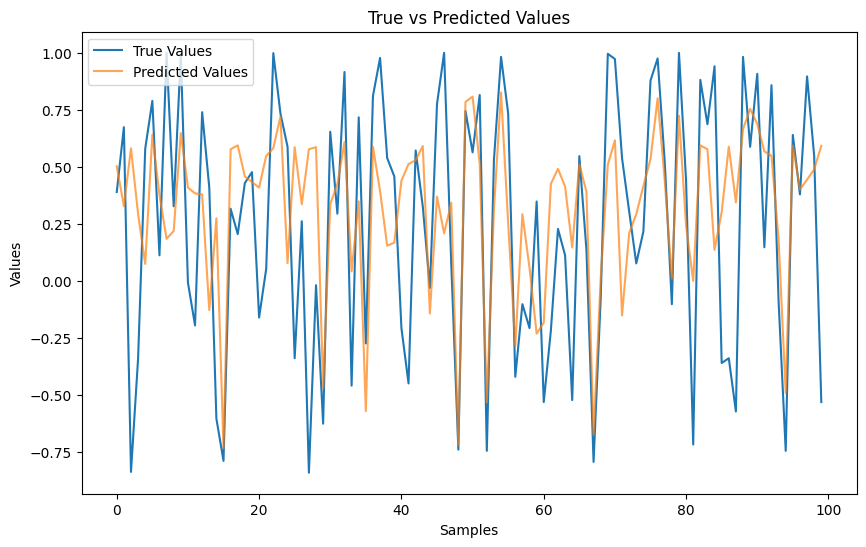

In [35]:
# Assurez-vous que le modèle est sur le bon appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Évaluation des performances
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for data, target in test_loader:
        # Déplacer les données et les cibles sur le GPU
        data, target = data.to(device), target.to(device)

        # Obtenir les prédictions
        output = model(data)

        # Déplacer les résultats sur le CPU
        y_pred.extend(output.cpu().numpy())
        y_true.extend(target.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error: {mse:.6f}')
print(f'Mean Absolute Error: {mae:.6f}')
print("Coefficient of Determination (R^2):", r2)

# Tracé des valeurs y_true et y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_true[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values', alpha=0.7)
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

# **Entrainement du modèle sans couches de neurones**

Importation des librairies

In [37]:
### MODEL REGRESSION LINEAIRE SANS RESEAUX DE NEURONES ###

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

Entrainement du modèle

Mean Squared Error: 1492.159628368682
Mean Absolute Error: 12.943257408309009
Coefficient of Determination (R^2): -4869.920065699722


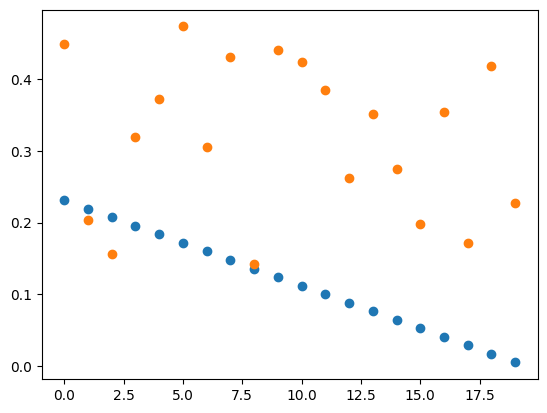

In [38]:
# Créer un modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train_standard, Y_train_standard)

# Faire des prédictions sur les données de test
predictions = model.predict(X_test_standard)

# Évaluer les performances du modèle
mse = mean_squared_error(Y_test_standard, predictions)
mae = mean_absolute_error(Y_test_standard, predictions)
r2 = r2_score(Y_test_standard, predictions)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Coefficient of Determination (R^2):", r2)

plt.plot(np.array(Y_test[:20]),'o')
plt.plot(predictions[:20],'o')
plt.show()

